## Baby LLM using tensorFlow
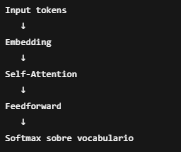

### Module 1: Input data

In [135]:
with open("input3.txt", "r", encoding="utf-8") as f:
    text = f.read()

# split into train and validation sets
data = text[:int(len(text)*0.9)]
val_data = text[int(len(text)*0.9):]

print(f"train has {len(data):,} characters")
print(f"val has {len(val_data):,} characters")

# here are all the unique characters that occur in this text
vocab_size = sorted(list(set(text)))
print("\nall the unique characters:", ''.join(vocab_size))
vocab_size = len(vocab_size)
print(f"total unique characters: {vocab_size:,}")


train has 265,560 characters
val has 29,507 characters

all the unique characters: 
 !"%'(),-.0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYabcdefghijklmnopqrstuvwxyz¡¿Ááéíñóúü—‘“”
total unique characters: 89


### Module 2: Tokenization

In [136]:
TOKENIZATION_TYPE = "word"
# opciones: "character" | "word" | "subword"

import tensorflow as tf

def build_tokenizer(text):

    if TOKENIZATION_TYPE == "character":
        vectorizer = tf.keras.layers.TextVectorization(
            standardize=None,
            split="character"
        )
        vectorizer.adapt([text])
        vocab = vectorizer.get_vocabulary()
        vocab_size = len(vocab)
        print(f"vocab: {vocab}")

        def encode(t):
            return vectorizer([t]).numpy()[0]
        
        def decode(t):
            return tf.strings.reduce_join([vocab[i] for i in t]).numpy().decode('utf-8')

        return encode, decode,  vocab_size

    elif TOKENIZATION_TYPE == "word":
        vectorizer = tf.keras.layers.TextVectorization(
            standardize="lower_and_strip_punctuation",
            split="whitespace"
        )
        vectorizer.adapt([text])
        vocab = vectorizer.get_vocabulary()
        vocab_size = len(vocab)
        print(f"vocab: {vocab}")

        def encode(t):
            return vectorizer([t]).numpy()[0]

        def decode(t):
            return ' '.join([vocab[i] for i in t])
        
        return encode, decode, vocab_size

    elif TOKENIZATION_TYPE == "subword":
        from tokenizers import Tokenizer
        from tokenizers.models import BPE
        from tokenizers.trainers import BpeTrainer
        from tokenizers.pre_tokenizers import Whitespace

        tokenizer = Tokenizer(BPE())
        tokenizer.pre_tokenizer = Whitespace()

        trainer = BpeTrainer(vocab_size=8000)
        tokenizer.train_from_iterator([text], trainer)

        vocab_size = tokenizer.get_vocab_size()

        def encode(t):
            return tokenizer.encode(t).ids
        
        def decode(t):
            return tokenizer.decode(t)

        return encode, decode, vocab_size

### Module 3: Encoding

In [137]:
encode, decode, vocab_size = build_tokenizer(text)
print(f"vocab size: {vocab_size}")

tokens = encode(text)
print(f"tokens : {len(tokens):,}")

vocab: ['', '[UNK]', np.str_('de'), np.str_('que'), np.str_('la'), np.str_('y'), np.str_('el'), np.str_('en'), np.str_('a'), np.str_('los'), np.str_('no'), np.str_('se'), np.str_('del'), np.str_('las'), np.str_('un'), np.str_('una'), np.str_('por'), np.str_('es'), np.str_('con'), np.str_('para'), np.str_('lo'), np.str_('nosotros'), np.str_('al'), np.str_('más'), np.str_('revolución'), np.str_('gobierno'), np.str_('o'), np.str_('su'), np.str_('si'), np.str_('como'), np.str_('pueblo'), np.str_('país'), np.str_('porque'), np.str_('todos'), np.str_('eso'), np.str_('nuestro'), np.str_('ha'), np.str_('estados'), np.str_('unidos'), np.str_('nos'), np.str_('aquí'), np.str_('problemas'), np.str_('cuba'), np.str_('hay'), np.str_('esa'), np.str_('ser'), np.str_('ese'), np.str_('todo'), np.str_('pero'), np.str_('puede'), np.str_('decir'), np.str_('tiene'), np.str_('han'), np.str_('mundo'), np.str_('ya'), np.str_('también'), np.str_('sus'), np.str_('derecho'), np.str_('este'), np.str_('sin'), np.st

### Module 4: Sequence Creation

In [138]:
BLOCK_SIZE = 64

X = []
Y = []

for i in range(len(tokens) - BLOCK_SIZE):
    X.append(tokens[i:i+BLOCK_SIZE])
    Y.append(tokens[i+1:i+BLOCK_SIZE+1])


X = tf.constant(X)
Y = tf.constant(Y)

print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")


print("\n--- Examples of how X → Y are constructed ---\n")
num_examples_to_show = 2 # you can change it
for i in range(num_examples_to_show):

    print(f"Example {i+1}")
    print("Context (X):", X[i].numpy())
    print("Target (Y):", Y[i].numpy())
    print("Explanation:")
    print("When the model sees:", X[i].numpy())
    print("It should predict: ", Y[i].numpy())
    print("-" * 60)


X shape: (48113, 64)
Y shape: (48113, 64)

--- Examples of how X → Y are constructed ---

Example 1
Context (X): [1431    5  135  196    2  551  282    7    3   11   36  101  802   58
   68    7    3   11   52  871  176   98    2  352    3  176    2  800
   52  112 5273  259  213  518 1232   59  848 3029 4318   74  779 6235
   97    5  124   15    2   13   98    3   11   52 3955   39   36 1528
    8   21    8    4  136   35 3241   10]
Target (Y): [   5  135  196    2  551  282    7    3   11   36  101  802   58   68
    7    3   11   52  871  176   98    2  352    3  176    2  800   52
  112 5273  259  213  518 1232   59  848 3029 4318   74  779 6235   97
    5  124   15    2   13   98    3   11   52 3955   39   36 1528    8
   21    8    4  136   35 3241   10   29]
Explanation:
When the model sees: [1431    5  135  196    2  551  282    7    3   11   36  101  802   58
   68    7    3   11   52  871  176   98    2  352    3  176    2  800
   52  112 5273  259  213  518 1232   59  848 3

### Module 5: Embedding (Demostration)

In [139]:
EMBED_DIM = 158

embedding = tf.keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=EMBED_DIM
)

print(f"Embedding layer created with vocab size {vocab_size} and embedding dimension {EMBED_DIM}.")

Embedding layer created with vocab size 6275 and embedding dimension 158.


### Module 6: Transformer

In [140]:
from tensorflow.keras import layers

num_heads = 4

def build_model(vocab_size):
    inputs = tf.keras.Input(shape=(BLOCK_SIZE,))

    # 1. Word Embedding + Position Embedding
    token_enbeddings = layers.Embedding(vocab_size, EMBED_DIM)(inputs)
    pos_enbeddings = layers.Embedding(BLOCK_SIZE, EMBED_DIM)(tf.range(start=0, limit=BLOCK_SIZE, delta=1))
    x = token_enbeddings + pos_enbeddings
    
    # 2. Bloque Transformer con Conexión Residual
    res = x
    x = layers.LayerNormalization()(x) # Pre Norm

    """ Q, K, V = x, x, x
    x = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=EMBED_DIM//num_heads
    )(Q, K, V) """

    x = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=EMBED_DIM // num_heads
    )(x, x, use_causal_mask=True) #Causal Mask to avoid seeing the future tokens
    x = layers.Add()([x, res]) # Residual Connection


    # 3. Feed Forward Network con Conexión Residual
    res = x
    x = layers.LayerNormalization()(x)
    x = layers.Dense(EMBED_DIM * 4, activation="relu")(x)
    x = layers.Dense(EMBED_DIM)(x)
    x = x + res # Residual Connection

    # 4. Output layer
    outputs = layers.Dense(vocab_size, activation="softmax")(x)

    return tf.keras.Model(inputs, outputs)


### Module 7: Pipeline

In [141]:
model = build_model(vocab_size)
model.summary()

model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
model.fit(X, Y, epochs=5)

# 1. Save the model weights and architecture
# Using the .keras extension is the modern standard
model.save("my_llm_model.keras")

# 2. Save the vocabulary (Crucial for the other program)
if TOKENIZATION_TYPE in ["character", "word"]:
    # Save the list of characters/words
    import json
    vocab = encode.__closure__[0].cell_contents.get_vocabulary()
    with open("vocab.json", "w") as f:
        json.dump(vocab, f)
elif TOKENIZATION_TYPE == "subword":
    # Save the BPE tokenizer files
    encode.__closure__[0].cell_contents.save("tokenizer.json")

print("Model and Tokenizer saved successfully!")


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_43        │ (None, 64, 158)   │    991,450 │ input_layer_16[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_37 (Add)        │ (None, 64, 158)   │          0 │ embedding_43[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 158)   │        316 │ add_37[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 158)   │     99,218 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_38 (Add)        │ (None, 64, 158)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_37[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 158)   │        316 │ add_38[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 64, 632)   │    100,488 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 64, 158)   │    100,014 │ dense_35[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_39 (Add)        │ (None, 64, 158)   │          0 │ dense_36[0][0],   │
│                     │                   │            │ add_38[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 64, 6275)  │    997,725 │ add_39[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,289,527 (8.73 MB)

 Trainable params: 2,289,527 (8.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 116s 76ms/step - loss: 1.8288
Epoch 2/5
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 126s 84ms/step - loss: 0.3316
Epoch 3/5
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 131s 87ms/step - loss: 0.2514
Epoch 4/5
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 152s 101ms/step - loss: 0.2159
Epoch 5/5
1504/1504 ━━━━━━━━━━━━━━━━━━━━ 155s 103ms/step - loss: 0.1956
Model and Tokenizer saved successfully!


### Module 8: Testing the learning

In [142]:
def generate_final_text(model, initial_text, total_length):
    input_tokens = list(encode(initial_text))
    
    for _ in range(total_length):
        # Window management
        pad_input = input_tokens[-BLOCK_SIZE:]
        if len(pad_input) < BLOCK_SIZE:
            pad_input = [0] * (BLOCK_SIZE - len(pad_input)) + pad_input
            
        # Prediction
        prediction = model.predict(tf.expand_dims(pad_input, 0), verbose=0)
        
        # Get the next token (last position in sequence)
        next_token = tf.argmax(prediction[0, -1, :]).numpy()
        input_tokens.append(next_token)
        
    return decode(input_tokens)

# --- EXECUTION ---
# This will now work regardless of character, word, or subword mode!
print(generate_final_text(model, "Cuba", 500))

cuba porque nos podía dependencia de estados unidos pero hay una mayoría del mundo que está porque alguno lo que podía dejar a nosotros nos vayamos a invocar ese peligro como un simple argumento nosotros nos consideramos y frente a esa africa que nos seguiremos considerando muy seriamente solicitar dentro de los cánones del derecho internacional la retirada de las fuerzas navales y militares argelia de esa porción del mundo está promoviendo la organización de movimientos subversivos contra se le disponga de la asistencia para nuestro gobierno revolucionario le quedará de lo denunciamos aquí militarismo alemán y que queremos denunciar concretamente que por ejemplo en una isla y que por ejemplo en filipinas y que lo embargo al gobierno revolucionario están considerando muy seriamente solicitar dentro de los cánones del derecho de la américa latina el gobierno revolucionario están expresamente proscripta por el régimen de los de toda costa rica que retirar esas fuerzas a los pueblos somet